In [1]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
pd.options.display.max_columns =70
from xgboost import XGBClassifier
path = 'QuakeMining/data/'

In [5]:
train_values = pd.read_csv(path + 'train_values.csv', index_col='building_id')
train_target = pd.read_csv(path + 'train_labels.csv', index_col='building_id')
test_values = pd.read_csv(path + 'test_values.csv')
train_values = train_values.reset_index()


# list all categorical features that we want to encode using OneHotEncoder
categorical_features = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']
encoder = OneHotEncoder()
encoded = pd.DataFrame(encoder.fit_transform(train_values[categorical_features]).toarray(), columns=encoder.get_feature_names(categorical_features))
train_val = train_values.drop(columns=categorical_features).join(encoded)

# list all numerical features that we want to re-scale
numeric_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage','count_families']

scaler = MinMaxScaler()
train_val[numeric_features] = scaler.fit_transform(train_val[numeric_features])
#display(train_val)

# create a train/test split
data_train, data_test, target_train, target_test = train_test_split(train_val, train_target, test_size=0.2, random_state=42)
display(data_train)
#display(target_train)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
170377,739427,13,257,8352,0.250,0.025126,0.010101,0.100000,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
184895,17201,6,1076,9202,0.250,0.040201,0.090909,0.200000,0,1,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,1,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26740,723805,7,838,10723,0.125,0.045226,0.070707,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
198210,891512,7,555,2763,0.125,0.030151,0.060606,0.066667,0,1,0,1,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
254313,484350,17,682,1039,0.250,0.030151,0.050505,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,79888,13,909,1626,0.125,0.025126,0.050505,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
103694,442764,10,1397,8182,0.125,0.005025,0.040404,0.066667,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
131932,17256,8,1073,5249,0.250,0.020101,0.212121,0.166667,0,1,0,0,0,0,1,0,0,0,0,0.111111,1,0,1,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
146867,496181,10,76,1841,0.250,0.010050,0.101010,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,

In [7]:
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomUnderSampler()
train_balanced_data, train_balanced_target = sampler.fit_resample(data_train, target_train)

## 1. Baselinemodell, RandomForestClassifier mit balanced data ohne hyperparameter tuning

In [11]:
clf = RandomForestClassifier()
clf.fit(train_balanced_data, train_balanced_target['damage_grade'])
pred = clf.predict(data_test)
acc = accuracy_score(target_test, pred)
f1_mic = f1_score(target_test, pred, average='micro')
f1_mac = f1_score(target_test, pred, average='macro')
print('The Accuracy is:{:,.4f}'.format(acc))
print('The f1_mic is:{:,.4f}'.format(f1_mic))
print('The f1_mac is:{:,.4f}'.format(f1_mac))

The Accuracy is:0.6222
The f1_mic is:0.6222
The f1_mac is:0.6057


## 1. Baselinemodell, XGBoostClassifier mit balanced data ohne hyperparameter tuning

In [10]:
model = XGBClassifier(use_label_encoder = True)
model.fit(train_balanced_data, train_balanced_target['damage_grade'])
pred = model.predict(data_test)

acc = accuracy_score(target_test, pred)
f1_mic = f1_score(target_test, pred, average='micro')
f1_mac = f1_score(target_test, pred, average='macro')
print('The Accuracy is:{:,.4f}'.format(acc))
print('The f1_mic is:{:,.4f}'.format(f1_mic))
print('The f1_mac is:{:,.4f}'.format(f1_mac))

C:\Users\luisa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:33:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The Accuracy is:0.6473
The f1_mic is:0.6473
The f1_mac is:0.6267


 --> XGBoost ist besseres Modell

## 2. Baseline Modell, XGBoostClassifier und Random Forest, ohne balanced data und ohne tuning

In [12]:
model = XGBClassifier()
model.fit(data_train, target_train)
pred = model.predict(data_test)

acc = accuracy_score(target_test, pred)
f1_mic = f1_score(target_test, pred, average='micro')
f1_mac = f1_score(target_test, pred, average='macro')
print('The Accuracy is:{:,.4f}'.format(acc))
print('The f1_mic is:{:,.4f}'.format(f1_mic))
print('The f1_mac is:{:,.4f}'.format(f1_mac))

C:\Users\luisa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisa\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[19:34:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The Accuracy is:0.7264
The f1_mic is:0.7264
The f1_mac is:0.6636


In [13]:
modelrf = RandomForestClassifier()
modelrf.fit(data_train, target_train)
predrf = modelrf.predict(data_test)

acc = accuracy_score(target_test, predrf)
f1_mic = f1_score(target_test, predrf, average='micro')
f1_mac = f1_score(target_test, predrf, average='macro')
print('The Accuracy is:{:,.4f}'.format(acc))
print('The f1_mic is:{:,.4f}'.format(f1_mic))
print('The f1_mac is:{:,.4f}'.format(f1_mac))

<ipython-input-13-68e1cd49b2fc>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelrf.fit(data_train, target_train)


The Accuracy is:0.7156
The f1_mic is:0.7156
The f1_mac is:0.6550


#### --> Balancing verschlechtert beide Modelle
### --> bestes Modell: XGBoost mit 0.7264

## Scatter Plot zur Visualisierung der Altersverteilung der Gebäude je Zerstörung und der Zerstörung der unterschiedlichen Distrikte

In [16]:
#train_values
data_ges = train_values.set_index(train_values['building_id']).join(train_target)

age_dmggrade = data_ges.groupby(['age','damage_grade']).agg({'building_id':'count'})
age_dmggrade = age_dmggrade.reset_index()
age_dmggrade = age_dmggrade[age_dmggrade['age']<=150]

geo = data_ges.groupby(['geo_level_1_id','damage_grade']).agg({'building_id':'count'}).reset_index()

### Verteilung der Zerstörung je nach Alter der Gebäude

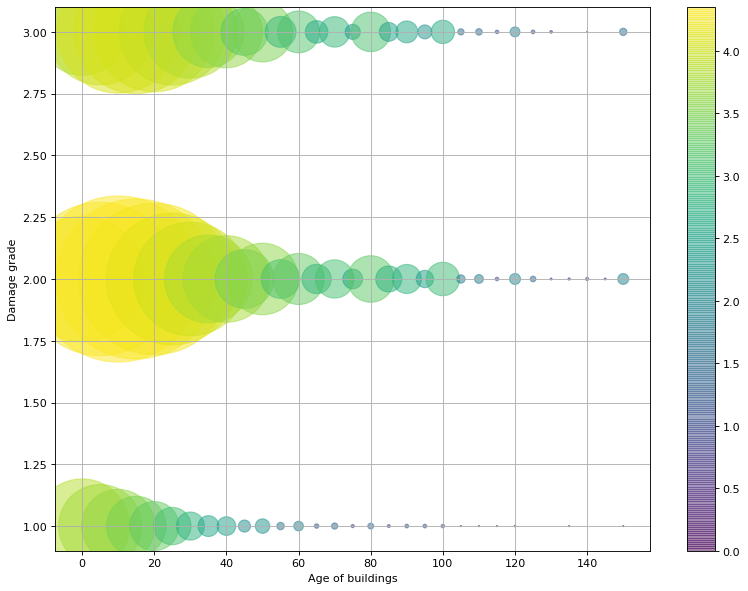

In [18]:
plt.figure(figsize=(12, 9), dpi=80)
plt.scatter(age_dmggrade['age'], age_dmggrade['damage_grade'], s=age_dmggrade['building_id'], c=np.log10(age_dmggrade['building_id']),  alpha=0.5)
plt.colorbar()
plt.xlabel('Age of buildings')
plt.ylabel('Damage grade')
plt.grid()
plt.show()

--> Aufteilung des Alters in unterschiedliche dummy Features

## Verteilung der Zerstörung je nach Distriktnummer

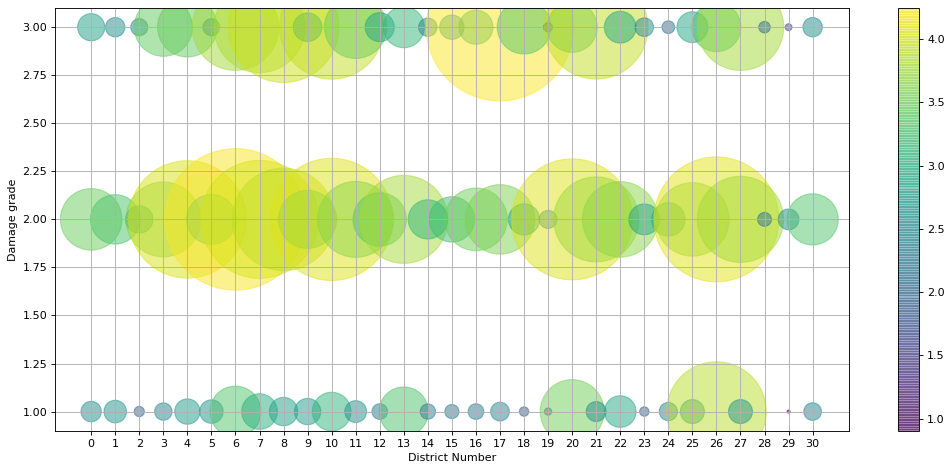

In [19]:
plt.figure(figsize=(16, 7), dpi=80)
plt.scatter(geo['geo_level_1_id'], geo['damage_grade'], s=geo['building_id'], c=np.log10(geo['building_id']), alpha=0.5)
plt.colorbar()
plt.xticks(np.arange(0, 31, step=1)) 
plt.xlabel('District Number')
plt.ylabel('Damage grade')
plt.grid()
plt.show()

--> Aufteilung der Distrikte in dummy features je nach Zerstörungsgrad

In [31]:
train_values = pd.read_csv(path + 'train_values.csv', index_col='building_id')
train_target = pd.read_csv(path + 'train_labels.csv', index_col='building_id')
test_values = pd.read_csv(path + 'test_values.csv')
train_values = train_values.reset_index()

#Erstellung der dummy features zum Alter der Gebäude
train_values.loc[(train_values['age'] <= 40),  'age_u_40'] = '1'
train_values.loc[(train_values['age'] > 40) , 'age_u_40'] = '0'
train_values.loc[(train_values['age'] > 40) & (train_values['age'] <= 100), 'age_40_100'] = '1'
train_values.loc[(train_values['age'] <= 40) | (train_values['age'] > 100), 'age_40_100'] = '0'
train_values.loc[(train_values['age'] >= 100),  'age_ue_100'] = '1'
train_values.loc[(train_values['age'] < 100),  'age_ue_100'] = '0'


#Erstellung der dummy features zu, Zerstörungsgrad der unterschiedlichen Distrikte
train_values.loc[ (train_values['geo_level_1_id'] == 14 ) | 
                 (train_values['geo_level_1_id'] == 15 ) | (train_values['geo_level_1_id'] == 2) |
                 (train_values['geo_level_1_id'] == 23 ) | (train_values['geo_level_1_id'] == 28) |
                 (train_values['geo_level_1_id'] == 19 ) | (train_values['geo_level_1_id'] == 29 ),  'district_class_1'] = '1'
train_values.loc[ (train_values['geo_level_1_id'] != 14 ) & 
                 (train_values['geo_level_1_id'] != 15 ) & (train_values['geo_level_1_id'] != 2) &
                 (train_values['geo_level_1_id'] != 23 ) & (train_values['geo_level_1_id'] != 28) &
                 (train_values['geo_level_1_id'] != 19 ) & (train_values['geo_level_1_id'] != 29 ),  'district_class_1'] = '0'

train_values.loc[(train_values['geo_level_1_id'] == 30 ) | (train_values['geo_level_1_id'] == 24 ) | 
                 (train_values['geo_level_1_id'] == 0 ) | (train_values['geo_level_1_id'] == 1) |
                 (train_values['geo_level_1_id'] == 16 ) | (train_values['geo_level_1_id'] == 12) |
                 (train_values['geo_level_1_id'] == 18 ) |
                 (train_values['geo_level_1_id'] == 5),  'district_class_2'] = '1'
train_values.loc[(train_values['geo_level_1_id'] != 0 ) & (train_values['geo_level_1_id'] != 30 ) & 
                 (train_values['geo_level_1_id'] != 24 ) & (train_values['geo_level_1_id'] != 1) &
                 (train_values['geo_level_1_id'] != 12 )  &
                 (train_values['geo_level_1_id'] != 16 ) & (train_values['geo_level_1_id'] != 18 ) &
                 (train_values['geo_level_1_id'] != 5 ),  'district_class_2'] = '0'

train_values.loc[(train_values['geo_level_1_id'] == 4 ) | (train_values['geo_level_1_id'] == 20 ) | 
                 (train_values['geo_level_1_id'] == 26 ),  'district_class_3'] = '1'
train_values.loc[(train_values['geo_level_1_id'] != 4 ) & (train_values['geo_level_1_id'] != 20 ) & 
                 (train_values['geo_level_1_id'] != 26 )  ,  'district_class_3'] = '0'

train_values.loc[(train_values['geo_level_1_id'] == 6 ) | (train_values['geo_level_1_id'] == 7 ) | 
                 (train_values['geo_level_1_id'] == 8 ) | (train_values['geo_level_1_id'] == 10) |
                 (train_values['geo_level_1_id'] == 21 ) | (train_values['geo_level_1_id'] == 17) 
                 ,  'district_class_4'] = '1'
train_values.loc[(train_values['geo_level_1_id'] != 6 ) & (train_values['geo_level_1_id'] != 7 ) & 
                 (train_values['geo_level_1_id'] != 8 ) & (train_values['geo_level_1_id'] != 10) &
                 (train_values['geo_level_1_id'] != 21 ) & (train_values['geo_level_1_id'] != 17) ,  'district_class_4'] = '0'

#numeric_transformer = Pipeline([ ('scaler', MinMaxScaler()) ])
# list all categorical features that we want to encode using OneHotEncoder
categorical_features = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']
#categorical_transformer = Pipeline([ ('onehot', OneHotEncoder()) ])

encoder = OneHotEncoder()

encoded = pd.DataFrame(encoder.fit_transform(train_values[categorical_features]).toarray(), columns=encoder.get_feature_names(categorical_features))
train_val = train_values.drop(columns=categorical_features).join(encoded)

# list all numerical features that we want to re-scale
numeric_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage','count_families','age_u_40','age_40_100','age_ue_100', 'district_class_1', 'district_class_2','district_class_3','district_class_4']

scaler = MinMaxScaler()
train_val[numeric_features] = scaler.fit_transform(train_val[numeric_features])
#display(train_val)

# create a train/test split
data_train, data_test, target_train, target_test = train_test_split(train_val, train_target, test_size=0.2, random_state=42)
display(data_train)
#display(target_train)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,age_u_40,age_40_100,age_ue_100,district_class_1,...,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
170377,739427,13,257,8352,0.250,0.025126,0.010101,0.100000,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
184895,17201,6,1076,9202,0.250,0.040201,0.090909,0.200000,0,1,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,1,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26740,723805,7,838,10723,0.125,0.045226,0.070707,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
198210,891512,7,555,2763,0.125,0.030151,0.060606,0.066667,0,1,0,1,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
254313,484350,17,682,1039,0.250,0.030151,0.050505,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,79888,13,909,1626,0.125,0.025126,0.050505,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
103694,442764,10,1397,8182,0.125,0.005025,0.040404,0.066667,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
131932,17256,8,1073,5249,0.250,0.020101,0.212121,0.166667,0,1,0,0,0,0,1,0,0,0,0,0.111111,1,0,1,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
146867,496181,10,76,1841,0.250,0.010050,0.101010,0.166

## XGBoost Modell zu allen Features inkl. dummy features

In [27]:
model = XGBClassifier(use_label_encoder = True)
model.fit(data_train, target_train)
pred = model.predict(data_test)

acc = accuracy_score(target_test, pred)
f1_mic = f1_score(target_test, pred, average='micro')
f1_mac = f1_score(target_test, pred, average='macro')
print('The Accuracy is:{:,.4f}'.format(acc))
print('The f1_mic is:{:,.4f}'.format(f1_mic))
print('The f1_mac is:{:,.4f}'.format(f1_mac))

C:\Users\luisa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisa\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[19:47:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The Accuracy is:0.7250
The f1_mic is:0.7250
The f1_mac is:0.6627


#### Auswertung der Feature Importance

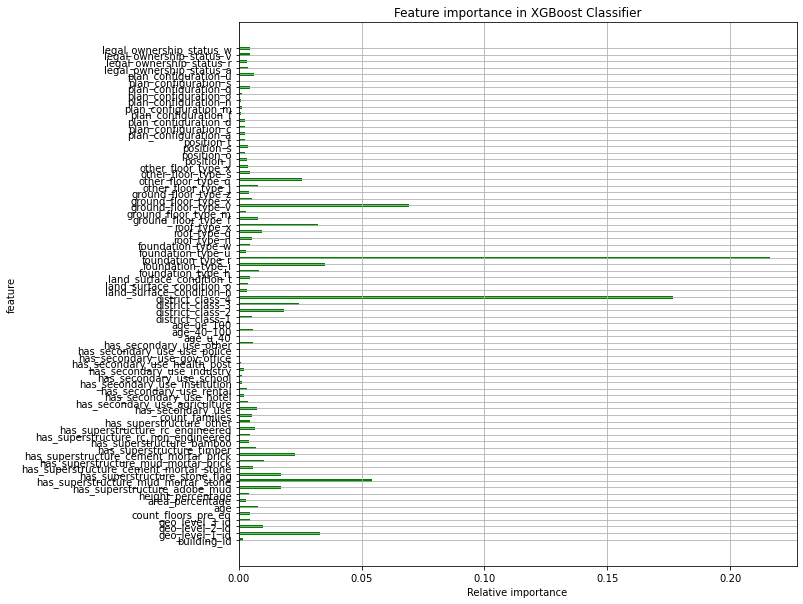

<Figure size 720x720 with 0 Axes>

In [28]:
#modelname.feature_importance_
y = model.feature_importances_

#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(data_train, minor=False)
plt.title('Feature importance in XGBoost Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.grid()
plt.figure(figsize=(10,10))
fig.set_size_inches(10, 10, forward=True)

Folgende Features sind unwichtig und könnten entfernt werden:
- secondary use office
- secondary use police
--> Zusammenfassen in secondary use other ausreichend?
- age ü 100
- age u 40

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    #plt.show()

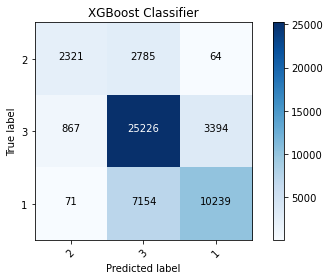

In [30]:
from sklearn.metrics import confusion_matrix    
import itertools
cnf_matrix= confusion_matrix(target_test, pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes = target_train['damage_grade'].unique(), title='XGBoost Classifier')

--> Probleme bei der Vorhersage und Unterscheidung zwischen damage grade 3 und 1

### Features auf folgende eingrenzen:

In [33]:
train_val = train_val[['geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'area_percentage',
 'height_percentage',
 'has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'count_families',
 'has_secondary_use',
 'age_u_40',
 'age_40_100',
 'age_ue_100',
 'district_class_1',
 'district_class_2',
 'district_class_3',
 'district_class_4',
 'land_surface_condition_n',
 'land_surface_condition_o',
 'land_surface_condition_t',
 'foundation_type_h',
 'foundation_type_i',
 'foundation_type_r',
 'foundation_type_u',
 'foundation_type_w',
 'roof_type_n',
 'roof_type_q',
 'roof_type_x',
 'ground_floor_type_f',
 'ground_floor_type_m',
 'ground_floor_type_v',
 'ground_floor_type_x',
 'ground_floor_type_z',
 'other_floor_type_j',
 'other_floor_type_q',
 'other_floor_type_s',
 'other_floor_type_x',
 'position_j',
 'position_o',
 'position_s',
 'position_t',
 'legal_ownership_status_a',
 'legal_ownership_status_r',
 'legal_ownership_status_v',
 'legal_ownership_status_w']]

# create a train/test split
data_train, data_test, target_train, target_test = train_test_split(train_val, train_target, test_size=0.2, random_state=42)
display(data_train)
#display(target_train)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,age_u_40,age_40_100,age_ue_100,district_class_1,district_class_2,district_class_3,district_class_4,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
170377,13,257,8352,0.250,0.025126,0.010101,0.100000,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
184895,6,1076,9202,0.250,0.040201,0.090909,0.200000,0,1,0,0,0,0,0,0,0,0,0,0.000000,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
26740,7,838,10723,0.125,0.045226,0.070707,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
198210,7,555,2763,0.125,0.030151,0.060606,0.066667,0,1,0,1,0,0,0,0,0,0,0,0.111111,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
254313,17,682,1039,0.250,0.030151,0.050505,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,13,909,1626,0.125,0.025126,0.050505,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.000000,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
103694,10,1397,8182,0.125,0.005025,0.040404,0.066667,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
131932,8,1073,5249,0.250,0.020101,0.212121,0.166667,0,1,0,0,0,0,1,0,0,0,0,0.111111,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
146867,10,76,1841,0.250,0.010050,0.101010,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [34]:
model2 = XGBClassifier(use_label_encoder = True)
model2.fit(data_train, target_train)
pred = model2.predict(data_test)

acc = accuracy_score(target_test, pred)
f1_mic = f1_score(target_test, pred, average='micro')
f1_mac = f1_score(target_test, pred, average='macro')
print('The Accuracy is:{:,.4f}'.format(acc))
print('The f1_mic is:{:,.4f}'.format(f1_mic))
print('The f1_mac is:{:,.4f}'.format(f1_mac))

C:\Users\luisa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisa\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[19:52:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The Accuracy is:0.7301
The f1_mic is:0.7301
The f1_mac is:0.6684


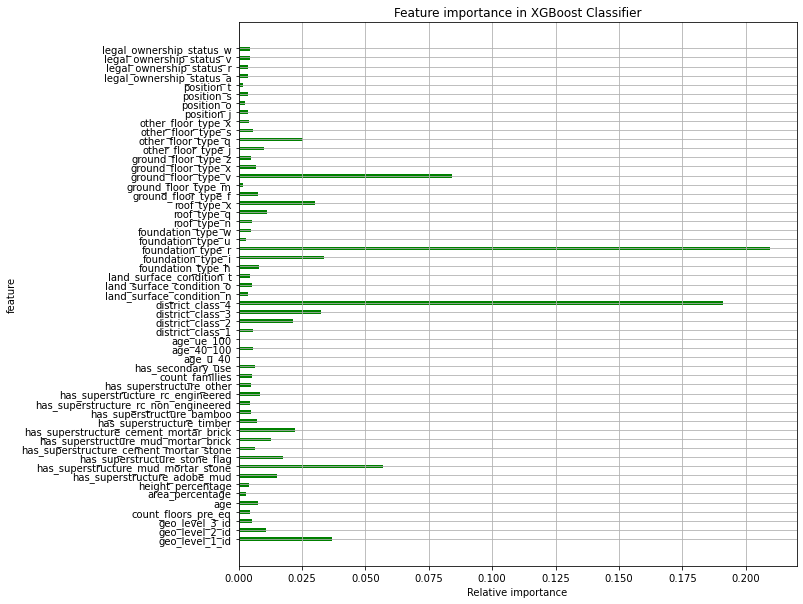

<Figure size 720x720 with 0 Axes>

In [35]:
#modelname.feature_importance_
y = model2.feature_importances_

#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(data_train, minor=False)
plt.title('Feature importance in XGBoost Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.grid()
plt.figure(figsize=(10,10))
fig.set_size_inches(10, 10, forward=True)

## Anpassen der Hyperparameter

In [36]:
model2 = XGBClassifier(use_label_encoder = True, booster='gbtree',verbosity=2, max_depth=10)
model2.fit(data_train, target_train)
pred = model2.predict(data_test)

acc = accuracy_score(target_test, pred)
f1_mic = f1_score(target_test, pred, average='micro')
f1_mac = f1_score(target_test, pred, average='macro')
print('The Accuracy is:{:,.4f}'.format(acc))
print('The f1_mic is:{:,.4f}'.format(f1_mic))
print('The f1_mac is:{:,.4f}'.format(f1_mac))

C:\Users\luisa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisa\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[19:55:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 1268 extra nodes, 0 pruned nodes, max_depth=10
[19:55:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 1672 extra nodes, 0 pruned nodes, max_depth=10
[19:55:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 1370 extra nodes, 0 pruned nodes, max_depth=10
[19:55:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:55:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 1322 extra nodes, 0 pruned nodes, max_de

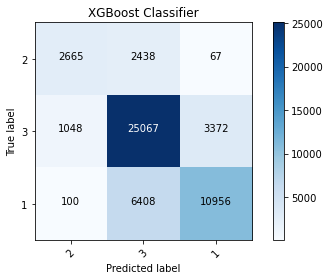

In [37]:
cnf_matrix= confusion_matrix(target_test, pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes = target_train['damage_grade'].unique(), title='XGBoost Classifier')